In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

In [3]:
radiomic_features_df = pd.read_table('Data\clinical_radiomics.tsv')

In [4]:
#Clean up
radiomic_features_df = radiomic_features_df[radiomic_features_df.OS_cens == '0']

radiomic_features_df["OS_result"] = radiomic_features_df["OS"] > 2.15 if 'long' else 'short'
radiomic_features_df = radiomic_features_df.drop(columns=["Image","Mask","type","CT_drugs","Treatment", "intent", "Metastasis_location", 
                                                          "diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy",
                                                          "diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet",
                                                          "diagnostics_Versions_Python","diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes",
                                                          "diagnostics_Image.original_Hash", "diagnostics_Image.original_Dimensionality", "diagnostics_Image.original_Spacing",
                                                          "diagnostics_Image.original_Minimum", "OS_cens","diagnostics_Image.original_Minimum", "OS", "diagnostics_Mask.original_Hash",
                                                          "diagnostics_Mask.original_Spacing", "diagnostics_Mask.original_BoundingBox",	"diagnostics_Mask.original_VoxelNum", "N",
                                                          "diagnostics_Mask.original_Size",  "diagnostics_Image.original_Size", "diagnostics_Mask.original_CenterOfMassIndex",	"diagnostics_Mask.original_CenterOfMass",
                                                          "CT_effect", "zubrod_score", "T", "HT", "PLT", "RBC", "WBC", "ID", "MFS","MFS_cens","CT_cycles", "histopathology", "location",
                                                           "MIP","RT_fractional_dose", "HB"])

In [5]:
X = radiomic_features_df.loc[:,radiomic_features_df.columns != "OS_result"]  #independent columns
y = radiomic_features_df.loc[:,radiomic_features_df.columns == "OS_result"]    #target column i.e price range

df1 = pd.get_dummies(X['sex'])
X = pd.concat([X, df1], axis=1).reindex(X.index)
X.drop('sex', axis=1, inplace=True)
std_slc = StandardScaler()

y = np.ravel(y)
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

data = pd.DataFrame(std_slc.fit_transform(dfscores), columns=dfscores.columns, index=dfscores.index)
featureScores = pd.concat([dfcolumns,data],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores)
#featureScores = featureScores. = ['Specs','Score']  #naming the dataframe columns

                                   Specs     Score
0                                    age -0.702046
1                          RT_total_dose  1.951725
2        diagnostics_Image.original_Mean -0.702046
3     diagnostics_Image.original_Maximum  0.721296
4    diagnostics_Mask.original_VolumeNum -0.702046
..                                   ...       ...
107            original_ngtdm_Complexity -0.157202
108              original_ngtdm_Contrast  0.612351
109              original_ngtdm_Strength -0.702046
110                               FEMALE -0.389556
111                                 MALE -0.702046

[112 rows x 2 columns]


In [6]:
features = featureScores.nlargest(15,'Score')['Specs']
print(features)
five_first_features = X[features [:5]] #first 5 features
five_ten_features = X[features [:10]] #first 10 features
fifteen_features = X[features] #15 features

32            original_firstorder_RootMeanSquared
97            original_gldm_HighGrayLevelEmphasis
27                       original_firstorder_Mean
21                     original_firstorder_Energy
34                original_firstorder_TotalEnergy
50                             original_glcm_Imc2
37                  original_glcm_Autocorrelation
28                     original_firstorder_Median
64    original_glrlm_LongRunHighGrayLevelEmphasis
1                                   RT_total_dose
16                     original_shape_SurfaceArea
8                  original_shape_MajorAxisLength
72                original_glrlm_ShortRunEmphasis
30                      original_firstorder_Range
40                     original_glcm_ClusterShade
Name: Specs, dtype: object



5 features
[[0.24678609 0.75321391]
 [0.97228159 0.02771841]
 [0.18832219 0.81167781]]
0.8861111111111111 {'pca__n_components': 3}
[ True False  True False  True False  True False False False False  True
  True False False False  True  True False  True  True  True  True False
  True False False False False False]




Text(0.5, 1.0, 'Results')

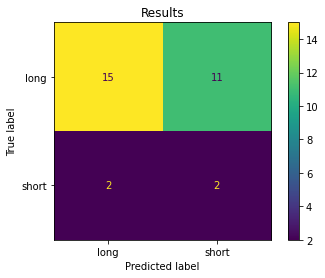

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

print("\n5 features")
X_train, X_test, y_train, y_test = train_test_split(five_first_features, y, test_size=0.4, random_state=0)
pca = PCA()
std_slc = StandardScaler()
model = GaussianNB()  #  Naive Bayes crng
pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('naive_bayes', model)])  # naive bayes crng

cv = KFold(n_splits=10, shuffle=True)

n_components = list(range(1, X.shape[1] + 1, 1))
parameters = dict(pca__n_components=n_components)

grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs = grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print(grid_search.best_score_, grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["long", "short"]
)
disp.ax_.set_title("Results")


5 features
[[0.52747083 0.47252917]
 [0.99758095 0.00241905]
 [0.56497915 0.43502085]]
0.861111111111111 {'pca__n_components': 5}
[False False False False False False  True False False False False False
  True False False False  True False  True False False False False False
 False False False False False False]




Text(0.5, 1.0, 'Results')

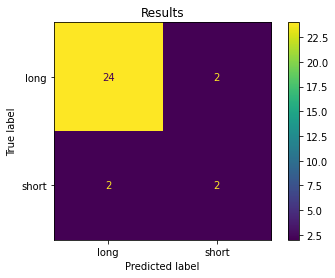

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

print("\n5 features")
X_train, X_test, y_train, y_test = train_test_split(five_ten_features, y, test_size=0.4, random_state=0)
pca = PCA()
std_slc = StandardScaler()
model = GaussianNB()  #  Naive Bayes crng
pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('naive_bayes', model)])  # naive bayes crng

cv = KFold(n_splits=10, shuffle=True)

n_components = list(range(1, X.shape[1] + 1, 1))
parameters = dict(pca__n_components=n_components)

grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs = grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print(grid_search.best_score_, grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["long", "short"]
)
disp.ax_.set_title("Results")


5 features
[[0.45652868 0.54347132]
 [0.94915932 0.05084068]
 [0.60390125 0.39609875]]
0.8416666666666668 {'pca__n_components': 1}
[ True False False False False False  True False False False False False
  True False False  True False False  True False  True  True  True False
 False False False False False False]




Text(0.5, 1.0, 'Results')

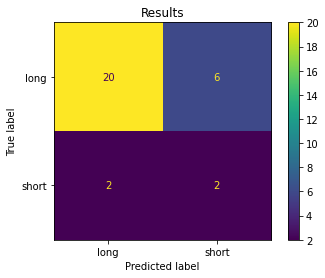

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

print("\n5 features")
X_train, X_test, y_train, y_test = train_test_split(fifteen_features, y, test_size=0.4, random_state=0)
pca = PCA()
std_slc = StandardScaler()
model = GaussianNB()  #  Naive Bayes crng
pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('naive_bayes', model)])  # naive bayes crng

cv = KFold(n_splits=10, shuffle=True)

n_components = list(range(1, X.shape[1] + 1, 1))
parameters = dict(pca__n_components=n_components)

grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs = grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print(grid_search.best_score_, grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["long", "short"]
)
disp.ax_.set_title("Results")